In this notebook we use gpytorch to implement gaussian processes.

In [1]:
import torch
import numpy as np
import gpytorch

from deepymod.data import Dataset
from deepymod.data.burgers import BurgersDelta

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Settings
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
#device = 'cpu'

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

sns.set()
%config InlineBackend.figure_format = 'svg'

In [3]:
# Making dataset
v = 0.1
A = 1.0

x = np.linspace(-3, 4, 40)
t = np.linspace(0.1, 5.0, 25)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(BurgersDelta, v=v, A=A)
X, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.2, random=False, normalize=False)
X, y = X.to(device), y.to(device)

In [6]:
network = torch.nn.Sequential(torch.nn.Linear(2, 50), 
                              torch.nn.Tanh(), 
                              torch.nn.Linear(50, 50), 
                              torch.nn.Tanh(), 
                              torch.nn.Linear(50, 2))

In [7]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, X, y, likelihood, embedding):
            super(GPRegressionModel, self).__init__(X, y, likelihood)
            self.mean_module = gpytorch.means.LinearMean(2)
            self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=5, ard_num_dims=2)
            #gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))
            self.embedding = embedding

        def forward(self, input):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            z = self.embedding(input)
            z = (z - z.min(axis=0)[0]) / (z.max(axis=0)[0] - z.min(axis=0)[0]) * 2 - 1

            mean_x = self.mean_module(z)
            covar_x = self.covar_module(z)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = GPRegressionModel(X, y.squeeze(), likelihood, network).to(device)

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [10]:
%%time
for epoch in torch.arange(5000):
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(X)
    # Calc loss and backprop derivatives
    loss = -mll(output, y.squeeze())
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(loss)

tensor(0.8536, device='cuda:0', grad_fn=<NegBackward>)
tensor(-1.5118, device='cuda:0', grad_fn=<NegBackward>)
tensor(-1.5153, device='cuda:0', grad_fn=<NegBackward>)
tensor(-1.6157, device='cuda:0', grad_fn=<NegBackward>)
tensor(-1.6560, device='cuda:0', grad_fn=<NegBackward>)
CPU times: user 2min 24s, sys: 101 ms, total: 2min 24s
Wall time: 2min 24s


In [11]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X))

/home/gert-jan/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [12]:
u = observed_pred.mean.reshape(x_grid.shape).detach().cpu().numpy()

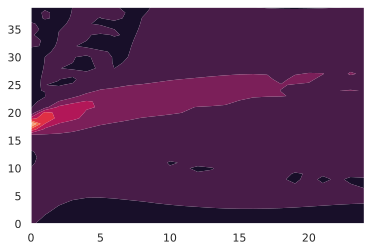

In [13]:
plt.contourf(u)

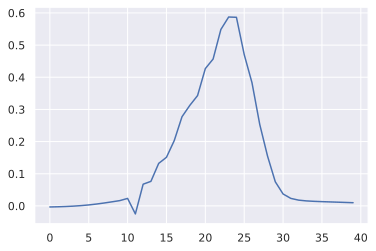

In [14]:
plt.plot(u[:, 10])

In [13]:
y_preds

MultivariateNormal(loc: torch.Size([1000]))

In [71]:
model.eval()

model(X)

MultivariateNormal(loc: torch.Size([1000]))

In [60]:
X.shape

torch.Size([1000, 2])

In [72]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(X)

RuntimeError: shape '[1000, 1000]' is invalid for input of size 1000

In [12]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))

Test MAE: 0.0678362175822258


In [39]:
import math
import tqdm
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

In [40]:
import urllib.request
import os
from scipy.io import loadmat
from math import floor


# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)


if not smoke_test and not os.path.isfile('../elevators.mat'):
    print('Downloading \'elevators\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1jhWL3YUHvXIaftia4qeAyDwVxo6j1alk', '../elevators.mat')


if smoke_test:  # this is for running the notebook in our testing framework
    X, y = torch.randn(20, 3), torch.randn(20)
else:
    data = torch.Tensor(loadmat('../elevators.mat')['data'])
    X = data[:, :-1]
    X = X - X.min(0)[0]
    X = 2 * (X / X.max(0)[0]) - 1
    y = data[:, -1]


train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [41]:
data_dim = train_x.size(-1)

class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(1000, 500))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(500, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 2))

feature_extractor = LargeFeatureExtractor()

In [42]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.feature_extractor(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [43]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [44]:
model(train_x)

MultivariateNormal(loc: torch.Size([13279]))

In [47]:
train_y.shape

torch.Size([13279])

In [49]:
import math

In [50]:
grid_bounds = [(0, 1), (0, 2)]
grid_size = 25
grid = torch.zeros(grid_size, len(grid_bounds))
for i in range(len(grid_bounds)):
    grid_diff = float(grid_bounds[i][1] - grid_bounds[i][0]) / (grid_size - 2)
    grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, grid_bounds[i][1] + grid_diff, grid_size)

train_x = gpytorch.utils.grid.create_data_from_grid(grid)
train_y = torch.sin((train_x[:, 0] + train_x[:, 1]) * (2 * math.pi)) + torch.randn_like(train_x[:, 0]).mul(0.01)


In [51]:
train_x

tensor([[-4.3478e-02, -8.6957e-02],
        [ 1.8116e-03, -8.6957e-02],
        [ 4.7101e-02, -8.6957e-02],
        ...,
        [ 9.5290e-01,  2.0870e+00],
        [ 9.9819e-01,  2.0870e+00],
        [ 1.0435e+00,  2.0870e+00]])

In [52]:
train_x.shape

torch.Size([625, 2])